In [11]:
from pygenomeviz import GenomeViz
from Bio.Seq import Seq
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy.stats as stats
import seaborn as sns
import os
import subprocess
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns 
sys.path.append('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/analysis')
from transcriptomics import *
from hcr import *
from plotting import * 
tr = load_transcriptome_object("/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/biroi_transcriptome.pkl")
white_plotting()

## OR DB 

In [12]:
# Load or_db
or_db = pd.read_excel('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

In [13]:
# iterate through each row of or_db 
for i, row in or_db.iterrows(): 
    gene = tr.get_gene(row.gene_name) 
    transcript = gene.get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    or_db.at[i,'start'] = bounds[0]
    or_db.at[i,'end'] = bounds[1] 
    or_db.at[i,'strand'] = transcript.strand 
    or_db.at[i, 'chr'] = transcript.chromosome
    or_db.at[i,'n_exons'] = len(transcript.exons)
    or_db.at[i,'nine_exon'] = "9E" in row['gene_name']
    or_db.at[i,'ta_size'] = or_db.loc[or_db.tandem_array == row['tandem_array']].shape[0]
or_db['start'] = or_db['start'].astype(int)
or_db['end'] = or_db['end'].astype(int)
or_db['ta_size'] = or_db['ta_size'].astype(int)
or_db['ta_index'] = or_db.groupby('tandem_array')['start'].rank(method='first', ascending=True).astype(int)

or_db.head(5)

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
0,1,Or5-R2,70,1,3',6504395,6510987,-,Chr1,8.0,False,2,1
1,1,Or5-Q1,70,2,5',6511625,6514800,-,Chr1,7.0,False,2,2
2,1,Or5-Orco,72,3,NaN,10910490,10919026,+,Chr1,9.0,False,2,1
3,1,Or5-Q2,72,4,NaN,10934666,10938750,+,Chr1,6.0,False,2,2
4,1,Or5-9E1,73,5,NaN,10980671,10984094,+,Chr1,6.0,True,1,1


In [14]:
# get chromosome sizes 
biroi_genome_fasta_path = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/genome/Obir.assembly.v5.4.fasta'
biroi_genome_seq = SeqIO.to_dict(SeqIO.parse(biroi_genome_fasta_path, "fasta"))

In [15]:
# Get the length of each chromosome 
biroi_chrom_sizes = {}
for chromosome, sequence in biroi_genome_seq.items():
    if chromosome.startswith('Chr'):
        biroi_chrom_sizes[chromosome] = len(sequence)
# convert to pandas 
biroi_chrom_sizes = pd.Series(biroi_chrom_sizes).reset_index()
biroi_chrom_sizes.columns = ['chromosome', 'length']
biroi_chrom_sizes

,chromosome,length
0,Chr1,24609146
1,Chr2,19224430
2,Chr3,18309999
3,Chr4,17779965
4,Chr5,17453326
5,Chr6,16888278
6,Chr7,16599821
7,Chr8,15891175
8,Chr9,15673213
9,Chr10,13842897


In [44]:
# Make a dataframe with a row for each TA 
TAs = or_db['tandem_array'].unique()
ta_db = pd.DataFrame(TAs, columns = ['tandem_array'])
for i, row in ta_db.iterrows(): 
    ta_genes = or_db[or_db['tandem_array'] == row['tandem_array']]
    ta_db.at[i, 'chromosome'] = ta_genes['chromosome'].values[0]
    gene_bounds = [tr.get_gene(gene).get_transcript_longest_bounds().get_bounds() for gene in ta_genes['gene_name'].values]
    ta_db.at[i, 'start'] = np.min(gene_bounds)
    ta_db.at[i, 'end'] = np.max(gene_bounds)
    ta_db.at[i, 'size'] = len(ta_genes)
# Set size to int 
ta_db['size'] = ta_db['size'].astype(int)
# Order by size 
ta_db = ta_db.sort_values('size', ascending = True)
ta_db

,tandem_array,chromosome,start,end,size
36,24,6.0,2176109.0,2178858.0,1
28,44,4.0,9019833.0,9044770.0,1
33,41,5.0,5542549.0,5547731.0,1
34,22,6.0,1281330.0,1295193.0,1
35,23,6.0,1936390.0,1940274.0,1
...,...,...,...,...,...
29,45,4.0,10512095.0,10680184.0,22
25,54,3.0,14747157.0,14843860.0,24
69,3,12.0,8696505.0,8810716.0,32
51,19,7.0,4833867.0,5147187.0,55


In [17]:
# Assign colors based on size 
unique_sizes = ta_db['size'].unique()
size_colors = sns.color_palette('Spectral', n_colors=len(unique_sizes))
size_to_color = {size: color for size, color in zip(unique_sizes, size_colors)}
ta_db['color'] = ta_db['size'].apply(lambda size: size_to_color[size])

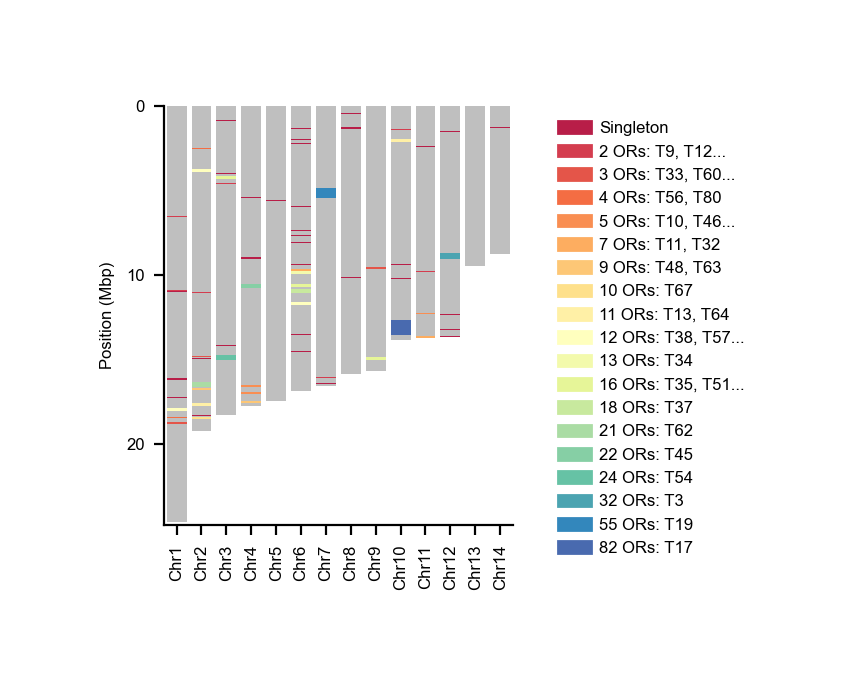

In [18]:
fontsize=8
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
max_legend_entries = 2
fig, axs = plt.subplots(1, 2, figsize=(3.5, 2.75), width_ratios=[0.8, 0.2], dpi=200)
white_plotting()

ax = axs[0]
# PLOT CHROMOSOMES 
for i, row in biroi_chrom_sizes.iterrows():
    rect = patches.Rectangle((i-0.4, 0), 0.8, row['length'], facecolor='gray', alpha=0.5)
    ax.add_patch(rect)

# PLOT TANDEM ARRAYS
for i, row in ta_db.iterrows():
    rect = patches.Rectangle((row['chromosome']-1.4, row['start']), 0.8, 50000 + 10000*row['size'], facecolor=row['color'], alpha=1)
    ax.add_patch(rect)

# PLOTTING 
ax.set_ylim(0, np.max(biroi_chrom_sizes['length']) + 200_000)
ax.set_xlim(-0.5, len(biroi_chrom_sizes)-0.5)
ax.set_xticks(range(len(biroi_chrom_sizes)), biroi_chrom_sizes['chromosome'], rotation=90, fontsize=6)
ax.set_ylabel('Position (Mbp)', fontsize=6)
#ax.set_title('Distribution of ORs Across Chromosomes', fontsize=6)
ax.set_yticks([0, 1e7, 2e7], ['0', "10", "20"], fontsize=6)
ax.invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# import rectangle
from matplotlib.patches import Rectangle

# LEGEND 
ax = axs[1]
color_groups = ta_db.groupby(['color', 'size'])['tandem_array'].apply(list).reset_index()
color_groups = color_groups.sort_values('size', ascending=True)
# Create legend patches with sorted size order, limiting the number of TAs displayed per entry
legend_patches = []
for _, row in color_groups.iterrows():
    # Limit the number of TAs shown to 5 per legend entry
    if row['size'] == 1: 
        #label = ', '.join(map(str, row['gene_name'][:max_legend_entries]))  # Show up to 5 TAs
        legend_label = f"Singleton"
    else:
        sorted_tas = sorted(row['tandem_array'])
        tas_display = "T" + ', T'.join(map(str, sorted_tas[:max_legend_entries]))
        if len(row['tandem_array']) > max_legend_entries:
            tas_display += "..."  # Add ellipsis if more TAs exist in the group
        legend_label = f"{row['size']} ORs: {tas_display}" 
    
    # Create the legend line2D 
    legend_patches.append(Rectangle((0, 0), 0.5, 0.5, color=row['color'], label=legend_label))

# Manually add the legend to the empty axis
legend = ax.legend(
    handles=legend_patches,
    loc='upper left',
    fontsize=6,
    frameon=False, 
    handletextpad=0.5
)

ax.axis('off')

plt.tight_layout()
plt.savefig("/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/lncRNA Paper/figure_pdfs/ORs-Chromosomes.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

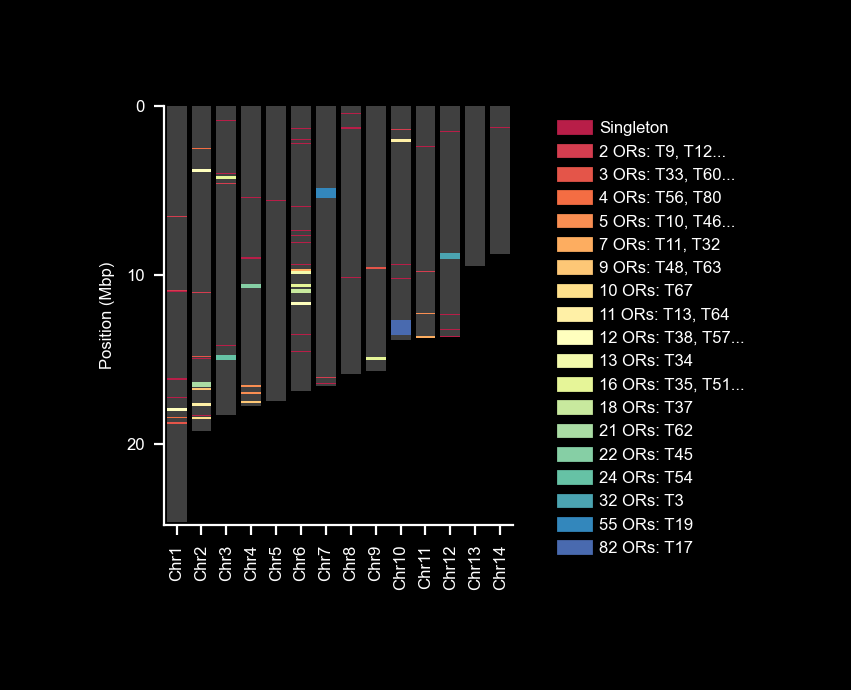

In [20]:
fontsize=8
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
max_legend_entries = 2
fig, axs = plt.subplots(1, 2, figsize=(3.5, 2.75), width_ratios=[0.8, 0.2], dpi=200)
black_plotting()

ax = axs[0]
# PLOT CHROMOSOMES 
for i, row in biroi_chrom_sizes.iterrows():
    rect = patches.Rectangle((i-0.4, 0), 0.8, row['length'], facecolor='gray', alpha=0.5)
    ax.add_patch(rect)

# PLOT TANDEM ARRAYS
for i, row in ta_db.iterrows():
    rect = patches.Rectangle((row['chromosome']-1.4, row['start']), 0.8, 50000 + 10000*row['size'], facecolor=row['color'], alpha=1)
    ax.add_patch(rect)

# PLOTTING 
ax.set_ylim(0, np.max(biroi_chrom_sizes['length']) + 200_000)
ax.set_xlim(-0.5, len(biroi_chrom_sizes)-0.5)
ax.set_xticks(range(len(biroi_chrom_sizes)), biroi_chrom_sizes['chromosome'], rotation=90, fontsize=6)
ax.set_ylabel('Position (Mbp)', fontsize=6)
#ax.set_title('Distribution of ORs Across Chromosomes', fontsize=6)
ax.set_yticks([0, 1e7, 2e7], ['0', "10", "20"], fontsize=6)
ax.invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# import rectangle
from matplotlib.patches import Rectangle

# LEGEND 
ax = axs[1]
color_groups = ta_db.groupby(['color', 'size'])['tandem_array'].apply(list).reset_index()
color_groups = color_groups.sort_values('size', ascending=True)
# Create legend patches with sorted size order, limiting the number of TAs displayed per entry
legend_patches = []
for _, row in color_groups.iterrows():
    # Limit the number of TAs shown to 5 per legend entry
    if row['size'] == 1: 
        #label = ', '.join(map(str, row['gene_name'][:max_legend_entries]))  # Show up to 5 TAs
        legend_label = f"Singleton"
    else:
        sorted_tas = sorted(row['tandem_array'])
        tas_display = "T" + ', T'.join(map(str, sorted_tas[:max_legend_entries]))
        if len(row['tandem_array']) > max_legend_entries:
            tas_display += "..."  # Add ellipsis if more TAs exist in the group
        legend_label = f"{row['size']} ORs: {tas_display}" 
    
    # Create the legend line2D 
    legend_patches.append(Rectangle((0, 0), 0.5, 0.5, color=row['color'], label=legend_label))

# Manually add the legend to the empty axis
legend = ax.legend(
    handles=legend_patches,
    loc='upper left',
    fontsize=6,
    frameon=False, 
    handletextpad=0.5
)

ax.axis('off')

plt.tight_layout()
plt.show()

In [75]:
ta_db = or_db.groupby('tandem_array').agg(chromosome=('chromosome', 'first'),
                                            start=('start', 'min'),
                                            end=('end', 'max'),
                                            size=('gene_name', 'count')).reset_index()
ta_db

,tandem_array,chromosome,start,end,size
0,2,12,1503224,1507800,1
1,3,12,8696505,8810716,32
2,5,12,12304523,12308947,1
3,6,12,13227042,13237610,1
4,7,12,13617769,13619604,1
...,...,...,...,...,...
69,85,9,9545011,9559445,3
70,86,9,14837358,14910386,16
71,88,8,399544,406595,1
72,89,8,1272627,1277556,1


In [79]:
ta_db_large = or_db.loc[or_db.ta_size > 5].copy() 
# Get unique colors for each tandem array
colors = sns.color_palette("husl", ta_db_large.tandem_array.nunique())
ta_db['color'] = ta_db.tandem_array.map(dict(zip(ta_db_large.tandem_array.unique(), colors)))
ta_db['color'] = ta_db['color'].fillna('black')
colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9702872692786527, 0.4593762250642383, 0.32668389068186215),
 (0.8729160523345536, 0.5301860515869471, 0.19559287758751898),
 (0.7757319041862729, 0.5784925270759935, 0.19475566538551875),
 (0.6960086430683907, 0.6097601692779926, 0.19416125627462036),
 (0.6147895506319775, 0.635570991994091, 0.1936384906440547),
 (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.19873498165924952, 0.6943120554063928, 0.42230983140847916),
 (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 (0.20852654360295203, 0.6802113380259018, 0.6131436043662991),
 (0.2123753265796856, 0.6743532091641877, 0.6722950863059881),
 (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 (0.22241706793970334, 0.6581658142406562, 0.8057515040597771),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 (0.6815956774120955, 0.5346981681234794, 0.9581962501093108),
 (0.8302781148974189, 0.4589877762395939, 0.9578861785214589),
 (0.9587050080494409, 0.3662259565791742, 0.9231469575614251),
 (0.9625878700929297, 0.400286255762724, 0.7887569980512142),
 (0.9653020460531215, 0.4222190504285544, 0.6726807888116159)]

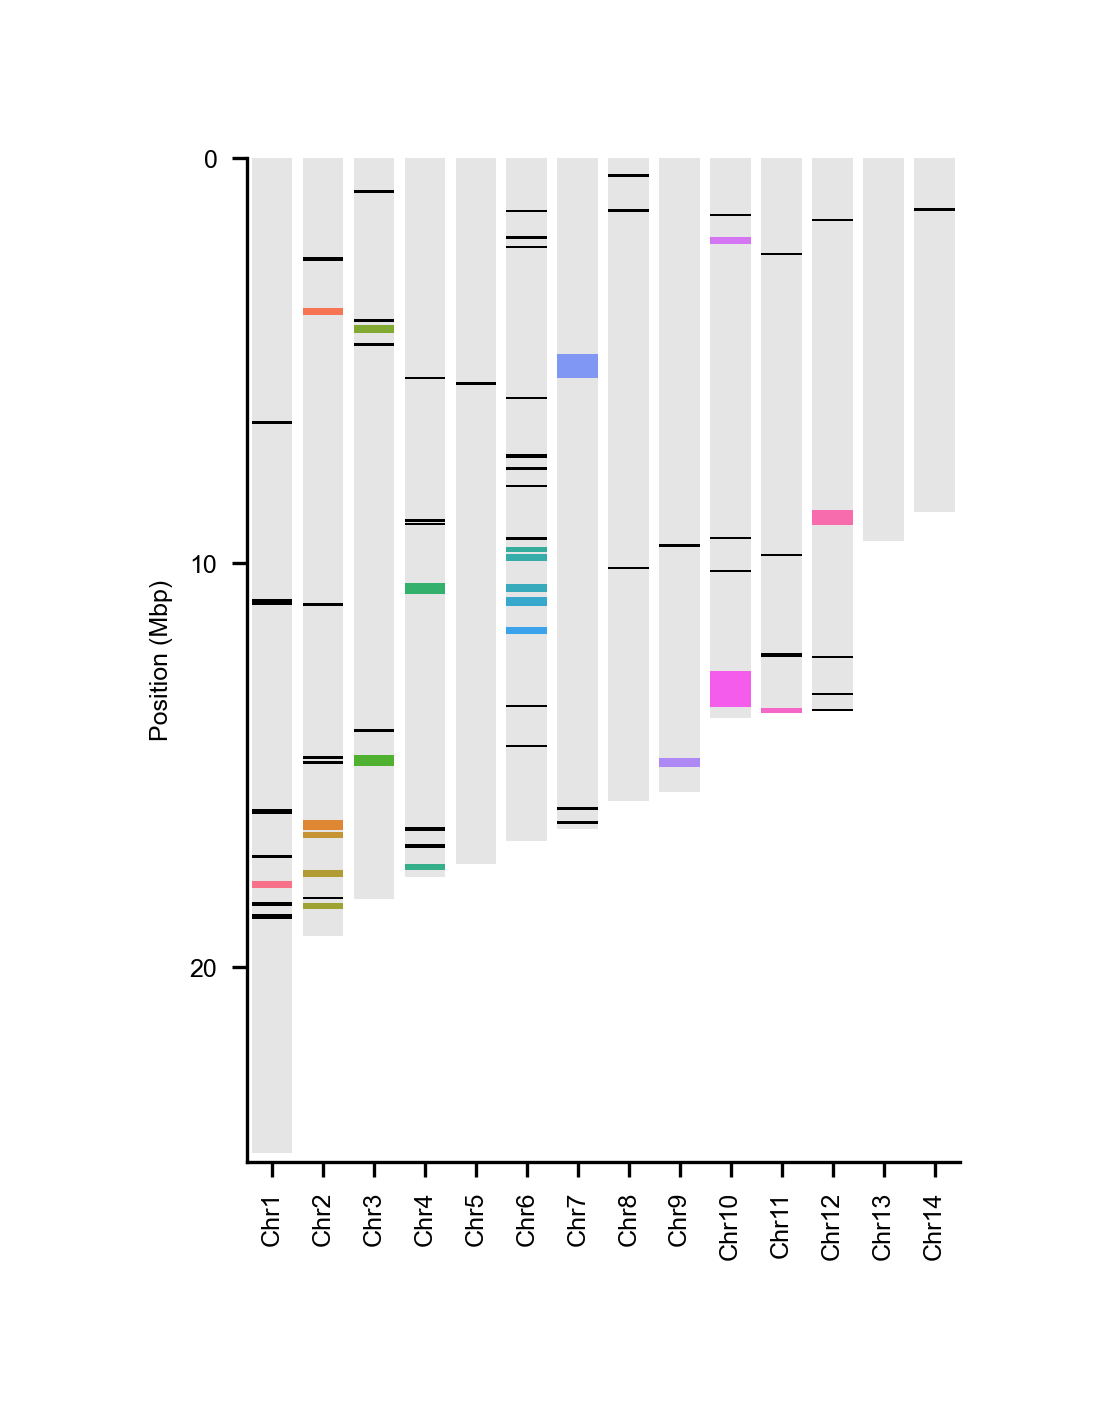

In [80]:
fontsize=8
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
max_legend_entries = 2
white_plotting()
fig, ax = plt.subplots(1, 1, figsize=(3, 4), dpi=300)

# PLOT CHROMOSOMES 
for i, row in biroi_chrom_sizes.iterrows():
    rect = patches.Rectangle((i-0.4, 0), 0.8, row['length'], facecolor='gray', alpha=0.2)
    ax.add_patch(rect)

# PLOT TANDEM ARRAYS
for i, row in ta_db.iterrows():
    rect = patches.Rectangle((row['chromosome']-1.4, row['start']), 0.8, 50000 + 10000*row['size'], facecolor=row['color'], alpha=1)
    ax.add_patch(rect)

# PLOTTING 
ax.set_ylim(0, np.max(biroi_chrom_sizes['length']) + 200_000)
ax.set_xlim(-0.5, len(biroi_chrom_sizes)-0.5)
ax.set_xticks(range(len(biroi_chrom_sizes)), biroi_chrom_sizes['chromosome'], rotation=90, fontsize=6, color='black')
ax.set_ylabel('Position (Mbp)', fontsize=6)
ax.set_yticks([0, 1e7, 2e7], ['0', "10", "20"], fontsize=6)
ax.invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

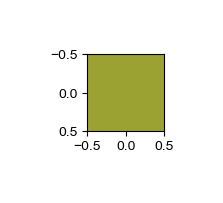

In [81]:
# Display color 
color = ta_db.loc[ta_db['tandem_array'] == 67, 'color'].values[0]
plt.figure(figsize=(1, 1))
plt.imshow([[color]])

## lncRNAs

In [25]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.gene_biotype == 'lncRNA']
all_lncRNAs_names = [gene.name for gene in all_lncRNAs]
len(all_lncRNAs_names)

1423

In [26]:
lnc_db = pd.DataFrame(all_lncRNAs_names, columns = ['gene_name'])
for i, row in lnc_db.iterrows(): 
    gene_object = tr.get_gene(row['gene_name'])
    if len(gene_object.transcripts) == 0: 
        continue
    lnc_db.at[i, 'chromosome'] = gene_object.chromosome
    bounds = gene_object.get_transcript_longest_bounds().get_bounds()
    lnc_db.at[i, 'start'] = bounds[0]
    lnc_db.at[i, 'end'] = bounds[1]

# remove nans 
lnc_db = lnc_db.dropna()

# Chromosome number: extract from "ChrX"
lnc_db['chr'] = lnc_db['chromosome'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

# size 
lnc_db['size'] = lnc_db['end'] - lnc_db['start']

# sort by chromosome, start 
lnc_db = lnc_db.sort_values(['chr', 'start']).reset_index(drop = True)
lnc_db

,gene_name,chromosome,start,end,chr,size
0,LOC113562166,Chr1,103515.0,108786.0,1,5271.0
1,LOC105288139,Chr1,260227.0,263340.0,1,3113.0
2,LOC113562147,Chr1,614991.0,620741.0,1,5750.0
3,LOC105286747,Chr1,1056151.0,1064257.0,1,8106.0
4,LOC113562536,Chr1,1290275.0,1295969.0,1,5694.0
...,...,...,...,...,...,...
1418,LOC109611224,Chr14,7773129.0,7773712.0,14,583.0
1419,LOC113563397,Chr14,7836244.0,7836714.0,14,470.0
1420,LOC113563398,Chr14,7837038.0,7837674.0,14,636.0
1421,LOC113563362,Chr14,8093770.0,8109749.0,14,15979.0


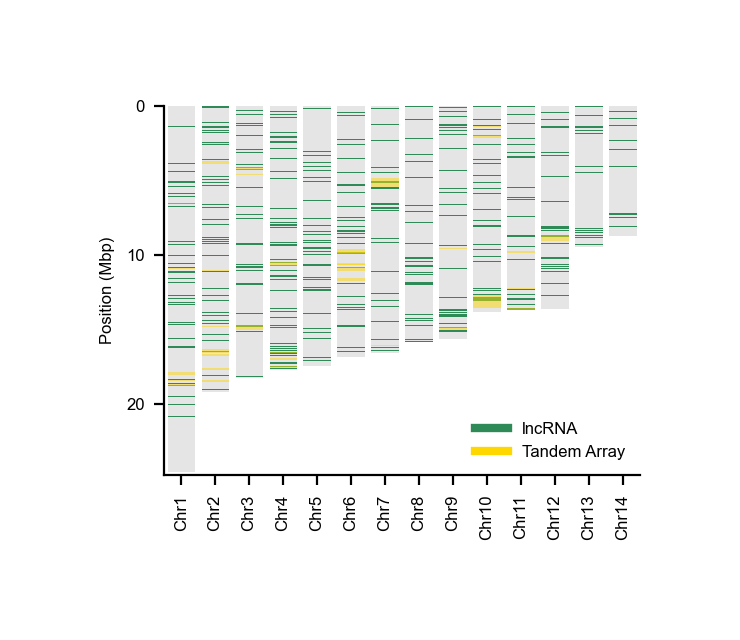

In [32]:
white_plotting() 
plt.figure(figsize=(3, 2.5), dpi=200)

# PLOT CHROMOSOMES 
for i, row in biroi_chrom_sizes.iterrows():
    rect = patches.Rectangle((i-0.4, 0), 0.8, row['length'], facecolor='gray', alpha=0.2)
    plt.gca().add_patch(rect)

# PLOT lncRNAs
for i, row in lnc_db.iterrows():
    rect = patches.Rectangle((row['chr']-1.4, row['start']), 0.8, 20_000, facecolor='seagreen', alpha=1)
    plt.gca().add_patch(rect)

# PLOT TANDEM ARRAYS
ta_db_subset = ta_db[ta_db['size'] > 1]
for i, row in ta_db_subset.iterrows():
    rect = patches.Rectangle((row['chromosome']-1.4, row['start']), 0.8, 50000 + 10000*row['size'], facecolor='gold', alpha=0.5)
    plt.gca().add_patch(rect)

# PLOTTING 
plt.ylim(0, np.max(biroi_chrom_sizes['length']) + 200_000)
plt.xlim(-0.5, len(biroi_chrom_sizes)-0.5)
plt.xticks(range(len(biroi_chrom_sizes)), biroi_chrom_sizes['chromosome'], rotation=90, fontsize=6)
plt.ylabel('Position (Mbp)', fontsize=6)
#plt.title('Distribution of ORs and lncRNAs Across Chromosomes', fontsize=6)
plt.gca().invert_yaxis()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yticks([0, 1e7, 2e7], ['0', "10", "20"], fontsize=6)

# Artificial legend
plt.plot([], [], color='seagreen', label='lncRNA', lw=3)
plt.plot([], [], color='gold', label='Tandem Array', lw=3)
plt.legend(loc='lower right', fontsize=6, frameon=False)

plt.tight_layout()
plt.savefig(f"/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/lncRNA Paper/figure_pdfs/lncRNA-and-ORs-Chromosomes.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()


## Black

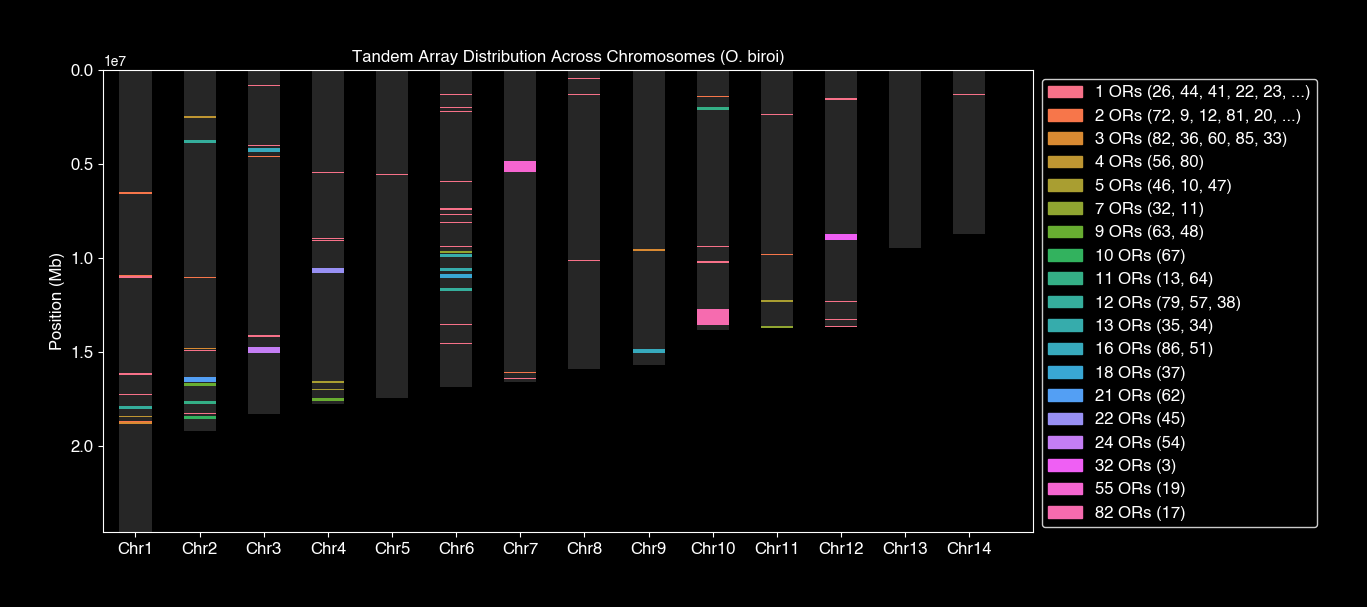

In [ ]:
max_legend_entries = 5 
black_plotting()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))


# PLOT CHROMOSOMES 
for i, row in biroi_chrom_sizes.iterrows():
    rect = patches.Rectangle((i-0.25, 0), 0.5, row['length'], facecolor='gray', alpha=0.3)
    ax.add_patch(rect)

# PLOT TANDEM ARRAYS
for i, row in ta_db.iterrows():
    rect = patches.Rectangle((row['chromosome']-1.25, row['start']), 0.5, 50000 + 10000*row['size'], facecolor=row['color'], alpha=1)
    ax.add_patch(rect)

# LEGEND 
color_groups = ta_db.groupby(['color', 'size'])['tandem_array'].apply(list).reset_index()
color_groups = color_groups.sort_values('size', ascending=True)
# Create legend patches with sorted size order, limiting the number of TAs displayed per entry
legend_patches = []
for _, row in color_groups.iterrows():
    # Limit the number of TAs shown to 5 per legend entry
    tas_display = ', '.join(map(str, row['tandem_array'][:max_legend_entries]))  # Show up to 5 TAs
    if len(row['tandem_array']) > max_legend_entries:
        tas_display += ", ..."  # Add ellipsis if more TAs exist in the group
    legend_label = f"{row['size']} ORs ({tas_display})"
    
    # Create the legend patch
    legend_patches.append(patches.Patch(color=row['color'], label=legend_label))

ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)  

# PLOTTING 
plt.ylim(0, np.max(biroi_chrom_sizes['length']))
plt.xlim(-0.5, len(biroi_chrom_sizes))
plt.xticks(range(len(biroi_chrom_sizes)), biroi_chrom_sizes['chromosome'], rotation=0, fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel('Position (Mb)', fontsize=12)
ax.set_title('Tandem Array Distribution Across Chromosomes (O. biroi)', fontsize=12)
ax.invert_yaxis()

plt.show()

## Q1 R2

In [ ]:
genes = ["Or5-Q1", "Or5-Q2", "Or5-Q3", "Or5-R2", "Or5-R3", "Or5-R1PSE"]

# Make a dataframe with a row for each TA 
gene_db = pd.DataFrame(genes, columns = ['gene'])
for i, row in gene_db.iterrows(): 
    gene_object = tr.get_gene(row['gene'])
    # get chromosome from "ChrX"
    gene_db.at[i, 'chromosome'] = int(re.findall(r'\d+', gene_object.chromosome)[0])
    bounds = gene_object.get_transcript_longest_bounds().get_bounds()
    gene_db.at[i, 'start'] = bounds[0]
    gene_db.at[i, 'end'] = bounds[1]

# Subtract 1000 from R2 start 
gene_db.at[3, 'start'] = gene_db.at[3, 'start'] - 300000

gene_db['color'] = sns.color_palette('husl', n_colors=len(gene_db))
gene_db

,gene,chromosome,start,end,color
0,Or5-Q1,1.0,6511625.0,6514800.0,"(0.9677975592919913, 0.44127456009157356, 0.53..."
1,Or5-Q2,1.0,10934666.0,10938750.0,"(0.7350228985632719, 0.5952719904750953, 0.194..."
2,Or5-Q3,3.0,14123612.0,14126968.0,"(0.3126890019504329, 0.6928754610296064, 0.192..."
3,Or5-R2,1.0,6204395.0,6510987.0,"(0.21044753832183283, 0.6773105080456748, 0.64..."
4,Or5-R3,8.0,399544.0,406595.0,"(0.23299120924703914, 0.639586552066035, 0.926..."
5,Or5-R1PSE,1.0,1402003.0,1404180.0,"(0.9082572436765556, 0.40195790729656516, 0.95..."


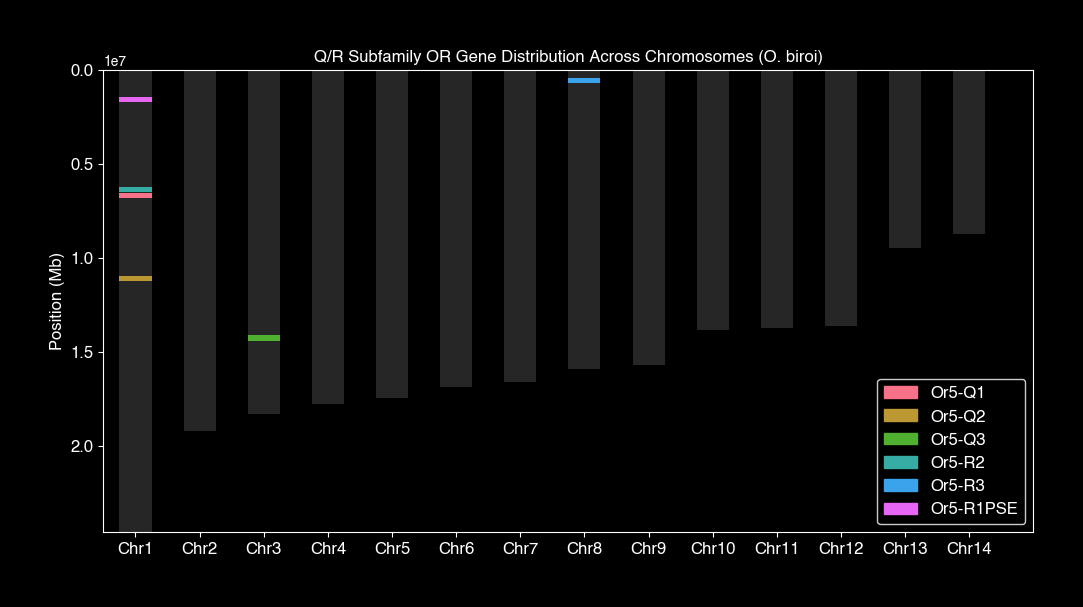

In [ ]:
max_legend_entries = 5 
black_plotting()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))


# PLOT CHROMOSOMES 
for i, row in biroi_chrom_sizes.iterrows():
    rect = patches.Rectangle((i-0.25, 0), 0.5, row['length'], facecolor='gray', alpha=0.3)
    ax.add_patch(rect)

# PLOT GENES 
for i, row in gene_db.iterrows():
    rect = patches.Rectangle((row['chromosome']-1.25, row['start']), 0.5, 300000, facecolor=row['color'], alpha=1)
    ax.add_patch(rect)

# Make simple legend 
legend_patches = []
for i, row in gene_db.iterrows():
    legend_patches.append(patches.Patch(color=row['color'], label=row['gene']))

ax.legend(handles=legend_patches, loc='lower right', fontsize=12)


# PLOTTING 
plt.ylim(0, np.max(biroi_chrom_sizes['length']))
plt.xlim(-0.5, len(biroi_chrom_sizes))
plt.xticks(range(len(biroi_chrom_sizes)), biroi_chrom_sizes['chromosome'], rotation=0, fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel('Position (Mb)', fontsize=12)
ax.set_title('Q/R Subfamily OR Gene Distribution Across Chromosomes (O. biroi)', fontsize=12)
ax.invert_yaxis()

plt.show()